In [1]:
#export
import pickle, gzip, math, os, time, shutil, torch, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial

from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset, load_dataset_builder

from fastprogress import master_bar, progress_bar

try:
    from .training import *
    from .datasets import *
    from .conv import *
except:
    from src.miniai.training import *
    from src.miniai.datasets import *
    from src.miniai.conv import *

In [2]:
# load fashion mnist dataset from huggingface
fmnist = load_dataset('fashion_mnist', ignore_verifications=True)

Reusing dataset fashion_mnist (/Users/diegomedina-bernal/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)
100%|██████████| 2/2 [00:00<00:00, 210.84it/s]


In [3]:
fmnist

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [4]:
# property names to interact with huggingface dataset
x = 'image'
y = 'label'

In [5]:
# inplace transform to convert to tensor
@inplace
def transform_(b):
    # batch of images -> transform to tensor
    # we could apply multiple transforms here
    b[x] = [TF.to_tensor(o) for o in b[x]]

# non-inplace transform to convert to tensor
def transform(b):
    # batch of images -> transform to tensor
    # we could apply multiple transforms here
    return {x: [TF.to_tensor(o) for o in b[x]]}

In [6]:
bs = 256
transformed_fmnist = fmnist.with_transform(transform_)

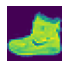

In [7]:
ds = transformed_fmnist['train']
img = ds[0][x]
show_image(img, figsize=(1,1));

In [8]:
collate_dict??

Signature: collate_dict(ds)
Docstring: <no docstring>
Source:   
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(default_collate(b))
    return _f
File:      ~/Documents/miniai/src/miniai/datasets.py
Type:      function


In [9]:
cf = collate_dict(ds)

In [10]:
cf

<function src.miniai.datasets.collate_dict.<locals>._f(b)>

In [11]:
def collate_(b): return to_device(cf(b))
def data_loaders(dsd, bs, **kwargs): return {k:DataLoader(v, bs, **kwargs) for k,v in dsd.items()}

In [12]:
dls = data_loaders(transformed_fmnist, bs, collate_fn=collate_)

In [13]:
dt = dls['train']
dv = dls['test']

In [14]:
xb, yb = next(iter(dt))

In [15]:
xb.shape, yb.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [16]:
dls

{'train': <torch.utils.data.dataloader.DataLoader at 0x13f13f5e0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x13f13f760>}

In [17]:
ds.features[y]

ClassLabel(num_classes=10, names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [18]:
itemgetter(*yb[:3])

operator.itemgetter(tensor(9, device='mps:0'), tensor(0, device='mps:0'), tensor(0, device='mps:0'))

In [19]:
labels = ds.features[y].names # list of labels
lbl_getter = itemgetter(*yb[:3])
titles = lbl_getter(labels)

In [20]:
titles

('Ankle boot', 'T - shirt / top', 'T - shirt / top')

# classifier

In [21]:
from torch import optim

bs = 256
lr = 0.4

In [22]:
cnn = nn.Sequential(
    conv(1, 4),
    conv(4, 8),
    conv(8, 16),
    conv(16, 16),
    conv(16, 10, act=False),
    nn.Flatten()).to(def_device)

In [23]:
cnn

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [24]:
opt = optim.SGD(cnn.parameters(), lr=lr)
loss, acc = fit(model=cnn, opt=opt, loss_fn=F.cross_entropy, train_dl=dt, valid_dl=dv, epochs=5)

0 0.7035704780578613 0.7464
1 0.7255051186084748 0.7336
2 0.5523931891441345 0.8045
3 0.4852148084640503 0.8249
4 0.5291839554309845 0.8113


## AutoEncoder

In [25]:
def deconv(ni, nf, ks=3, act=True):
    """This deconv layer will be composed of a nearest neighbor upsample, followed by a convolution with a stride of 1"""
    layers = [
        nn.UpsamplingNearest2d(scale_factor=2), # scale factor of 2
        nn.Conv2d(ni, nf, kernel_size=ks, padding=ks//2, stride=1),
    ]
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [33]:
# model evaluation function
def eval(model, loss_fn, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss, count = 0, 0
        for xb, _ in valid_dl:
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_fn(pred, xb).item() * n
    print(f'Epoch {epoch}: loss = {tot_loss/count:.4f}')

In [34]:
# rewriting our fit function to include evaluation
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, _ in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, xb) # we are reconstructing the input, therefor our loss will take the output and input as parameters
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model, loss_fn, valid_dl, epoch)

In [35]:
# constructing our autoencoder
ae = nn.Sequential(
    nn.ZeroPad2d(2), # 28x28 -> 32x32
    conv(1, 2), # 32x32 -> 16x16
    conv(2, 4), # 16x16 -> 8x8
    conv(4, 8), # 8x8 -> 4x4 # bottleneck
    deconv(8, 4), # 4x4 -> 8x8
    deconv(4, 2), # 8x8 -> 16x16
    deconv(2, 1, act=False), # 16x16 -> 32x32
    nn.ZeroPad2d(-2), # 32x32 -> 28x28
    nn.Sigmoid()).to(def_device) # squish the output between 0 and 1

In [36]:
# let's train
opt = optim.SGD(ae.parameters(), lr=0.1)
fit(
    epochs=5,
    model=ae,
    loss_fn=F.mse_loss, # we are reconstructing the input, therefor our loss will take the output and input as parameters
    opt=opt,
    train_dl=dt,
    valid_dl=dv
)

Epoch 0: loss = 0.1235
Epoch 1: loss = 0.0730
Epoch 2: loss = 0.0399
Epoch 3: loss = 0.0332
Epoch 4: loss = 0.0302


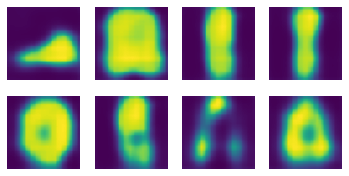

In [39]:
# how well does it get recreated?
xb, _ = next(iter(dv))
preds = ae(xb)
show_images(preds[:8].data.cpu(), imsize=1.5)

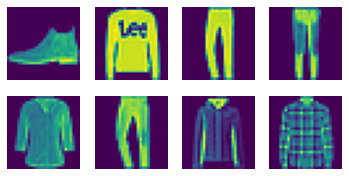

In [40]:
# how well does it get recreated?
xb, _ = next(iter(dv))
preds = ae(xb)
show_images(xb[:8].data.cpu(), imsize=1.5)